In [1]:
! pip install -q /kaggle/input/keras-cv-core-namex/namex-0.0.7-py3-none-any.whl
! pip install -q /kaggle/input/keras-cv-core-namex/keras_core-0.1.4-py3-none-any.whl
! pip install -q /kaggle/input/keras-cv-core-namex/keras_cv-0.6.1-py3-none-any.whl

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras_core as keras
import keras_cv

import gc
import cv2
import pydicom
from joblib import Parallel, delayed

import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from glob import glob

Using TensorFlow backend


In [3]:
BASE_PATH = "/kaggle/input/rsna-2023-abdominal-trauma-detection"
IMAGE_DIR = "/tmp/dataset/rsna-atd"
INPUT_MODEL_PATH = "/input/rsna-train-keras-yolov8/yolov8_xl_atd.keras"
MODEL_PATH = "/kaggle/working/yolov8_xl_atd.keras"

STRIDE = 10

In [4]:
class Config:
    IMAGE_SIZE = [256, 256]
    RESIZE_DIM = 256
    BATCH_SIZE = 32
    AUTOTUNE = tf.data.AUTOTUNE
    TARGET_COLS  = ["bowel_healthy", "bowel_injury", "extravasation_healthy",
                   "extravasation_injury", "kidney_healthy", "kidney_low",
                   "kidney_high", "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"]

config = Config()

In [5]:
!cp /kaggle/input/rsna-train-keras-yolov8/yolov8_xl_atd.keras /kaggle/working/


In [6]:
model = keras.models.load_model(MODEL_PATH)

In [7]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (32, 256, 256, 3) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ global_average_poo… │ (32, 3)           │       0 │ input_layer[0][0]    │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (32, 32)          │     128 │ global_average_pool… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_1 (Dense)     │ (32, 32)          │     128 │ global_average_pool… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_2 (Dense)     │ (32, 32)          │     128 │ global_average_pool… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_3 (Dense)     │ (32, 32)          │     128 │ global_average_pool… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_4 (Dense)     │ (32, 32)          │     128 │ global_average_pool… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ bowel (Dense)       │ (32, 1)           │      33 │ dense[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ extra (Dense)       │ (32, 1)           │      33 │ dense_1[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ liver (Dense)       │ (32, 3)           │      99 │ dense_2[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ kidney (Dense)      │ (32, 3)           │      99 │ dense_3[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ spleen (Dense)      │ (32, 3)           │      99 │ dense_4[0][0]        │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 1,003 (31.34 KB)

 Trainable params: 1,003 (31.34 KB)

 Non-trainable params: 0 (0.00 B)

DATA PIPELINE

In [8]:
meta_df = pd.read_csv(f'{BASE_PATH}/test_series_meta.csv')

meta_df.head()

,patient_id,series_id,aortic_hu
0,48843,295,401.25
1,48843,62825,238.00
2,50046,24574,149.00
3,50046,60658,352.00
4,63706,39279,219.00


In [9]:
#looking for duplicate values
num_rows = meta_df.shape[0]
unique_patients = meta_df['patient_id'].value_counts()

print(f"{num_rows=}")
print(f"{unique_patients=}")

num_rows=6
unique_patients=patient_id
48843    2
50046    2
63706    2
Name: count, dtype: int64


In [10]:
meta_df.shape

(6, 3)

In [11]:
#PREPROCESSING 

meta_df["dicom_folder"] = BASE_PATH + "/" + "test_images"\
                                    + "/" + meta_df.patient_id.astype(str)\
                                    + "/" + meta_df.series_id.astype(str)

meta_df.head()

,patient_id,series_id,aortic_hu,dicom_folder
0,48843,295,401.25,/kaggle/input/rsna-2023-abdominal-trauma-detec...
1,48843,62825,238.00,/kaggle/input/rsna-2023-abdominal-trauma-detec...
2,50046,24574,149.00,/kaggle/input/rsna-2023-abdominal-trauma-detec...
3,50046,60658,352.00,/kaggle/input/rsna-2023-abdominal-trauma-detec...
4,63706,39279,219.00,/kaggle/input/rsna-2023-abdominal-trauma-detec...


In [12]:
test_folders = meta_df.dicom_folder.to_list()
test_paths = []
for folder in tqdm(test_folders):
    test_paths += sorted(glob(os.path.join(folder, '*dcm')))[::STRIDE]

  0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
test_df = pd.DataFrame(test_paths, columns=["dicom_path"])
test_df["patient_id"] = test_df.dicom_path.map(lambda x: x.split("/")[-3]).astype(int)
test_df["series_id"] = test_df.dicom_path.map(lambda x: x.split("/")[-2]).astype(int)
test_df["instance_number"] = test_df.dicom_path.map(lambda x: x.split("/")[-1].replace(".dcm","")).astype(int)

test_df["image_path"] = f"{IMAGE_DIR}/test_images"\
                    + "/" + test_df.patient_id.astype(str)\
                    + "/" + test_df.series_id.astype(str)\
                    + "/" + test_df.instance_number.astype(str) +".png"

test_df.head()

,dicom_path,patient_id,series_id,instance_number,image_path
0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,48843,62825,30,/tmp/dataset/rsna-atd/test_images/48843/62825/...
1,/kaggle/input/rsna-2023-abdominal-trauma-detec...,50046,24574,30,/tmp/dataset/rsna-atd/test_images/50046/24574/...
2,/kaggle/input/rsna-2023-abdominal-trauma-detec...,63706,39279,30,/tmp/dataset/rsna-atd/test_images/63706/39279/...


In [14]:
# Checking if patients are repeated by finding the number of unique patient IDs
num_rows = test_df.shape[0]
unique_patients = test_df["patient_id"].nunique()

print(f"{num_rows=}")
print(f"{unique_patients=}")


num_rows=3
unique_patients=3


DICOM TO PNG PIPELINE

In [15]:
!rm -r {IMAGE_DIR}
os.makedirs(f"{IMAGE_DIR}/train_images", exist_ok=True)
os.makedirs(f"{IMAGE_DIR}/test_images", exist_ok=True)

rm: cannot remove '/tmp/dataset/rsna-atd': No such file or directory


In [16]:
def standardize_pixel_array(dcm):
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        new_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)
    return pixel_array

def read_xray(path, fix_monochrome=True):
    dicom = pydicom.dcmread(path)
    data = standardize_pixel_array(dicom)
    data = data - np.min(data)
    data = data / (np.max(data) + 1e-5)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
    return data

def resize_and_save(file_path):
    img = read_xray(file_path)
    h, w = img.shape[:2]  # orig hw
    img = cv2.resize(img, (config.RESIZE_DIM, config.RESIZE_DIM), cv2.INTER_LINEAR)
    img = (img * 255).astype(np.uint8)
    
    sub_path = file_path.split("/",4)[-1].split(".dcm")[0] + ".png"
    infos = sub_path.split("/")
    sub_path = file_path.split("/",4)[-1].split(".dcm")[0] + ".png"
    infos = sub_path.split("/")
    pid = infos[-3]
    sid = infos[-2]
    iid = infos[-1]; iid = iid.replace(".png","")
    new_path = os.path.join(IMAGE_DIR, sub_path)
    os.makedirs(new_path.rsplit("/",1)[0], exist_ok=True)
    cv2.imwrite(new_path, img)
    return

In [17]:
%%time

file_paths = test_df.dicom_path.tolist()
_ = Parallel(n_jobs=2, backend="threading")(
    delayed(resize_and_save)(file_path) for file_path in tqdm(file_paths, leave=True, position=0)
)

del _; gc.collect()

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 390 ms, sys: 61.3 ms, total: 451 ms
Wall time: 476 ms


117

tf.data pipeline

In [18]:
def decode_image(image_path):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0
    return image

def build_dataset(image_paths):
    ds = (
        tf.data.Dataset.from_tensor_slices(image_paths)
        .map(decode_image, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [19]:
paths = test_df.image_path.to_list()

ds = build_dataset(paths)

images = next(iter(ds))

images.shape

TensorShape([3, 256, 256, 3])

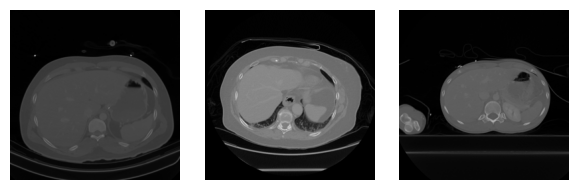

In [20]:
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=1,
    cols=3,
)

In [21]:
def post_proc(pred):
    proc_pred = np.empty((pred.shape[0], 2*2 + 3*3), dtype="float32")

    # bowel, extravasation
    proc_pred[:, 0] = pred[:, 0]
    proc_pred[:, 1] = 1 - proc_pred[:, 0]
    proc_pred[:, 2] = pred[:, 1]
    proc_pred[:, 3] = 1 - proc_pred[:, 2]
    
    # liver, kidney, sneel
    proc_pred[:, 4:7] = pred[:, 2:5]
    proc_pred[:, 7:10] = pred[:, 5:8]
    proc_pred[:, 10:13] = pred[:, 8:11]

    return proc_pred

In [22]:
# Getting unique patient IDs from test dataset
patient_ids = test_df["patient_id"].unique()

# Initializing array to store predictions
patient_preds = np.zeros(
    shape=(len(patient_ids), 2*2 + 3*3),
    dtype="float32"
)

# Iterating over each patient
for pidx, patient_id in tqdm(enumerate(patient_ids), total=len(patient_ids), desc="Patients "):
    print(f"Patient ID: {patient_id}")
    
    # Query the dataframe for a particular patient
    
    patient_df = test_df.query("patient_id == patient_id")
    
    # Getting image paths for a patient
    patient_paths = patient_df.image_path.tolist()

    # Building dataset for prediction
    dtest = build_dataset(patient_paths)
    
    # Predicting with the model
    pred = model.predict(dtest)
    pred = np.concatenate(pred, axis=-1).astype("float32")
    pred = pred[:len(patient_paths), :]
    pred = np.mean(pred.reshape(1, len(patient_paths), 11), axis=0)
    pred = np.max(pred, axis=0, keepdims=True)
    
    patient_preds[pidx, :] += post_proc(pred)[0]
    

    # Deleting variables to free up memory 
    del patient_df, patient_paths, dtest, pred; gc.collect()

Patients :   0%|          | 0/3 [00:00<?, ?it/s]

Patient ID: 48843
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Patient ID: 50046
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Patient ID: 63706
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Submission

In [23]:
!rm -rf {MODEL_PATH}


In [24]:
# Create Submission
pred_df = pd.DataFrame({"patient_id":patient_ids,})
pred_df[config.TARGET_COLS] = patient_preds.astype("float32")

# Align with sample submission
sub_df = pd.read_csv(f"{BASE_PATH}/sample_submission.csv")
sub_df = sub_df[["patient_id"]]
sub_df = sub_df.merge(pred_df, on="patient_id", how="left")

# Store submission
sub_df.to_csv("submission.csv",index=False)
sub_df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.564078,0.435922,0.620353,0.379647,0.85583,0.108929,0.094243,0.772142,0.21276,0.081506,0.632719,0.225277,0.202442
1,50046,0.564078,0.435922,0.620353,0.379647,0.85583,0.108929,0.094243,0.772142,0.21276,0.081506,0.632719,0.225277,0.202442
2,63706,0.564078,0.435922,0.620353,0.379647,0.85583,0.108929,0.094243,0.772142,0.21276,0.081506,0.632719,0.225277,0.202442


In [25]:
sub_df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.564078,0.435922,0.620353,0.379647,0.85583,0.108929,0.094243,0.772142,0.21276,0.081506,0.632719,0.225277,0.202442
1,50046,0.564078,0.435922,0.620353,0.379647,0.85583,0.108929,0.094243,0.772142,0.21276,0.081506,0.632719,0.225277,0.202442
2,63706,0.564078,0.435922,0.620353,0.379647,0.85583,0.108929,0.094243,0.772142,0.21276,0.081506,0.632719,0.225277,0.202442
